<a href="https://colab.research.google.com/github/EnmaSantos/CSE450/blob/main/bikers_model_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the training dataset
data_url = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv"
data = pd.read_csv(data_url)

In [3]:
# Load the holdout dataset
holdout_url = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv"
holdout = pd.read_csv(holdout_url)

In [4]:
# Add the 'count' column to the training dataset
data['count'] = data['casual'] + data['registered']

In [5]:
# Drop the 'casual' and 'registered' columns
data = data.drop(columns=['casual', 'registered'])

# Convert 'dteday' to datetime format
data['dteday'] = pd.to_datetime(data['dteday'])
holdout['dteday'] = pd.to_datetime(holdout['dteday'])

# Function to engineer features
def engineer_features(df):
    df = df.copy()

    # Extract temporal features
    df['year'] = df['dteday'].dt.year
    df['month'] = df['dteday'].dt.month
    df['day'] = df['dteday'].dt.day
    df['day_of_week'] = df['dteday'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Cyclical encoding for hour (captures time of day patterns)
    df['hour_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hr'] / 24)

    # Cyclical encoding for month (captures seasonal patterns)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Cyclical encoding for day of week (captures weekly patterns)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Interaction features (capture combined effects)
    df['temp_hum'] = df['temp_c'] * df['hum']  # Hot and humid days impact differently
    df['temp_windspeed'] = df['temp_c'] * df['windspeed']  # Wind chill effect
    df['hum_windspeed'] = df['hum'] * df['windspeed']  # Combined weather impact

    # Enhanced holiday/workingday features
    df['special_day'] = ((df['holiday'] == 1) | (df['is_weekend'] == 1)).astype(int)

    # Create hour groups with unique labels
    df['hour_group'] = pd.cut(df['hr'],
                              bins=[-1, 5, 11, 16, 20, 24],
                              labels=['early_morning', 'morning', 'afternoon', 'evening', 'night'])

    # Create "rush hour" feature (typical commuting times)
    df['rush_hour'] = ((df['hr'] >= 7) & (df['hr'] <= 9) |
                       (df['hr'] >= 16) & (df['hr'] <= 18)).astype(int)

    # Weather and holiday interaction (bad weather on holidays has different impact)
    df['weather_holiday'] = df['weathersit'] * df['holiday']

    # COVID-19 periods (since dataset spans 2011-2023)
    df['pre_covid'] = (df['dteday'] < '2020-03-01').astype(int)
    df['early_covid'] = ((df['dteday'] >= '2020-03-01') & (df['dteday'] < '2021-06-01')).astype(int)
    df['late_covid'] = ((df['dteday'] >= '2021-06-01') & (df['dteday'] < '2022-04-01')).astype(int)
    df['post_covid'] = (df['dteday'] >= '2022-04-01').astype(int)

    # Long-term trend capture (years since start of data)
    df['years_since_start'] = (df['dteday'].dt.year - 2011) + (df['dteday'].dt.month - 1)/12

    # Interaction between COVID periods and other features
    df['covid_weather'] = ((df['early_covid'] == 1) | (df['late_covid'] == 1)) * df['weathersit']
    df['covid_weekend'] = ((df['early_covid'] == 1) | (df['late_covid'] == 1)) * df['is_weekend']

    # Create one-hot encoding for hour_group
    hour_group_dummies = pd.get_dummies(df['hour_group'], prefix='hour_group')
    df = pd.concat([df.drop(columns=['hour_group']), hour_group_dummies], axis=1)

    # Drop 'dteday' after extracting all features
    df = df.drop(columns=['dteday'])

    return df

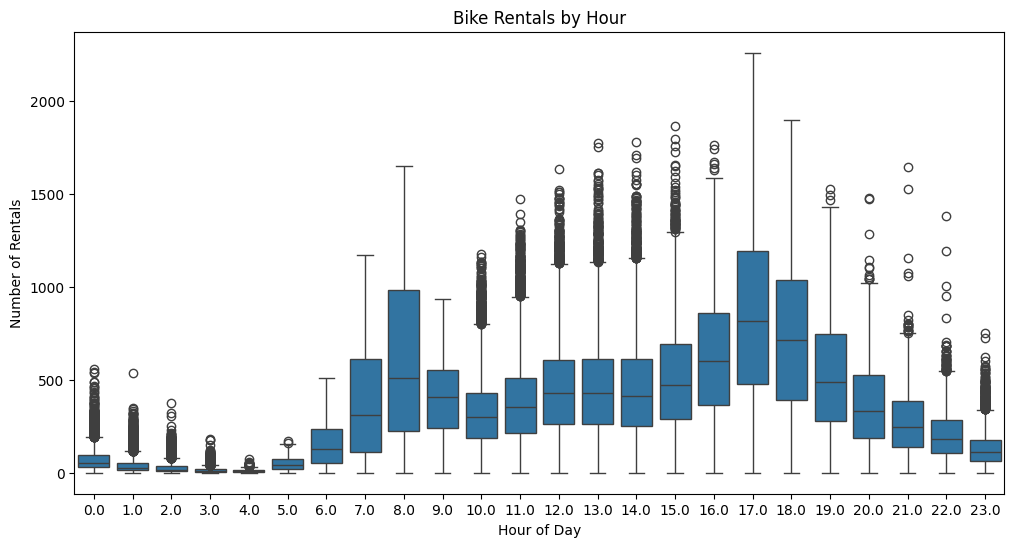

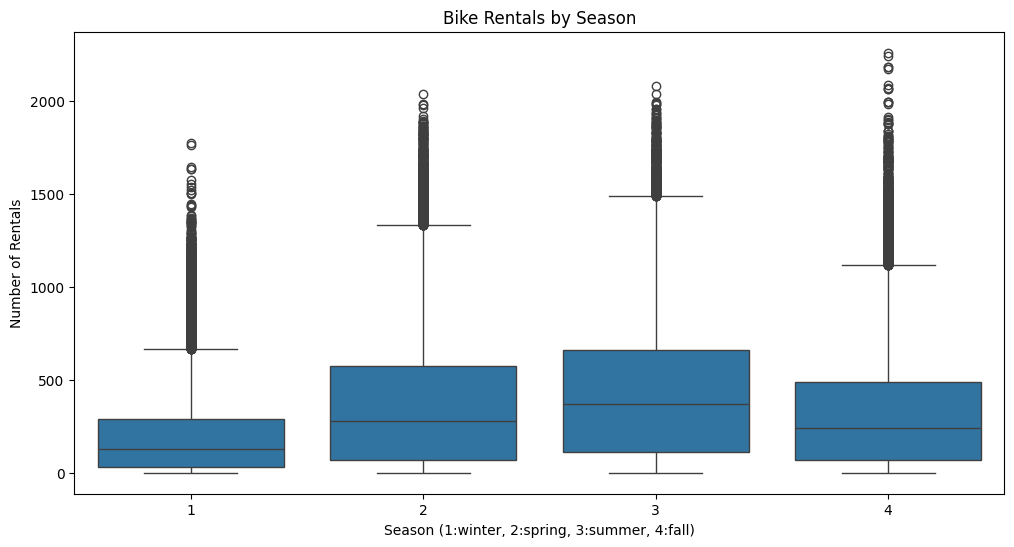

In [6]:
# Apply feature engineering
data = engineer_features(data)
holdout = engineer_features(holdout)

# Visualize the relationship between hour and count
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['hr'], y=data['count'])
plt.title('Bike Rentals by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rentals')
plt.show()

# Visualize the relationship between season and count
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['season'], y=data['count'])
plt.title('Bike Rentals by Season')
plt.xlabel('Season (1:winter, 2:spring, 3:summer, 4:fall)')
plt.ylabel('Number of Rentals')
plt.show()

In [ ]:
# Identify categorical features
categorical_features = ['season', 'weathersit', 'holiday', 'workingday']

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(data[categorical_features])
encoded_columns = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns)
data = pd.concat([data.drop(columns=categorical_features), encoded_df], axis=1)

# Identify numerical features (exclude 'count' and any other non-feature columns)
numerical_features = [col for col in data.columns
                      if col not in ['count', 'instant']
                      and not col.startswith('season_')
                      and not col.startswith('weathersit_')
                      and not col.startswith('holiday_')
                      and not col.startswith('workingday_')]

# Normalize numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Define features (X) and target (y)
X = data.drop(columns=['count'])
y = data['count']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training a gradient boosting model first to determine feature importance...")
# Train a gradient boosting model to identify important features
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 most important features:")
print(feature_importances.head(15))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

Training a gradient boosting model first to determine feature importance...


In [ ]:
print("\nNow training the neural network model...")
# Build the neural network with attention to the most important features
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='relu')  # ReLU activation ensures non-negative predictions
])

# Compile the model with a better optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Increased epochs but using early stopping
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Process the holdout dataset
# One-hot encode categorical features
encoded_features_holdout = encoder.transform(holdout[categorical_features])
encoded_df_holdout = pd.DataFrame(encoded_features_holdout, columns=encoded_columns)
holdout = pd.concat([holdout.drop(columns=categorical_features), encoded_df_holdout], axis=1)

# Ensure holdout has the same columns as X_train
for col in X_train.columns:
    if col not in holdout.columns:
        holdout[col] = 0  # Add missing columns with default value

# Reorder columns to match X_train
holdout = holdout[X_train.columns]

# Normalize numerical features
holdout[numerical_features] = scaler.transform(holdout[numerical_features])

In [ ]:
# Generate predictions
predicted_counts = model.predict(holdout).flatten()

# Post-processing to ensure predictions are positive integers
predicted_counts = np.maximum(0, predicted_counts)  # Ensure non-negative
predicted_counts = predicted_counts.round(0).astype(int)

# Save predictions to a CSV file
results = pd.DataFrame({'count': predicted_counts})
results.to_csv("team8-bike-rental-predictions.csv", index=False)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Output model summary and evaluation metrics
print("\nModel Summary:")
model.summary()

print("\nTraining completed with early stopping at epoch:",
      len(history.history['loss']))

print("\nValidation Loss:", history.history['val_loss'][-1])
print("Validation MAE:", history.history['val_mae'][-1])

print("\nChecking for negative or extreme predictions:")
print("Min prediction:", min(predicted_counts))
print("Max prediction:", max(predicted_counts))
print("Average prediction:", sum(predicted_counts)/len(predicted_counts))

# Additional insights
print("\nDistribution of predictions:")
bins = [0, 50, 100, 200, 500, 1000, float('inf')]
bin_labels = ['0-50', '51-100', '101-200', '201-500', '501-1000', '1000+']
prediction_distribution = pd.cut(predicted_counts, bins=bins, labels=bin_labels)
print(pd.value_counts(prediction_distribution, normalize=True).sort_index() * 100)

# Check if we have good variety in our predictions (not just the same value repeated)
unique_predictions = len(set(predicted_counts))
print(f"\nNumber of unique prediction values: {unique_predictions} out of {len(predicted_counts)} predictions")
print(f"Percentage of unique values: {unique_predictions/len(predicted_counts)*100:.2f}%")